In [3]:
import os
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
from scipy import stats



#Feature importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler


#importing machine learning libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle



#Secondary imports
import pandas_profiling as pp
from scipy.stats import pearsonr
import pickle


%matplotlib inline

## Reading Datasets

In [4]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sample = pd.read_csv('Sample_submission.csv')



In [14]:
cols = np.load('final_col.npy').tolist()

In [15]:
remove = []

for i in range(len(cols)):
    value = (1 - train[train[cols[i]]!=0].shape[0]/train.shape[0]) * 100
    if value > 60:
        remove.append(cols[i])


for i in range(len(remove)):
    cols.remove(remove[i])

In [16]:
data = train[(np.abs(stats.zscore(train[cols])) < 3).all(axis=1)][cols].copy()
target = train[(np.abs(stats.zscore(train[cols])) < 3).all(axis=1)]['Col2'].copy()


In [17]:
lgbb = lgb.LGBMClassifier()
# ctb = CatBoostClassifier(verbose=False)

# xgbb = xgb.XGBClassifier()

n_split = 5
avg1 = 0
avg2 = 0
count=0

skf = StratifiedKFold(n_splits = n_split, shuffle = True)

for train_index, test_index in skf.split(train[cols], train['Col2']):
    print("hello", count)
    count+=1
   
    trainx, testx = train[cols].iloc[train_index], train[cols].iloc[test_index]
    trainy, testy = train['Col2'].iloc[train_index], train['Col2'].iloc[test_index]
    
    lgbb.fit(trainx, trainy)
#     ctb.fit(trainx, trainy)
    avg1 += accuracy_score(lgbb.predict(testx), testy)
#     avg2 += accuracy_score(ctb.predict(testx), testy)


print("Average accuracy was: ", avg1/n_split)#,"and", avg2/6)
    
    

hello 0
hello 1
hello 2
hello 3
hello 4
Average accuracy was:  0.8978368964102164


In [18]:
avg2/5

0.0

In [20]:
lgbb = lgb.LGBMClassifier()
# xgbb = xgb.XGBClassifier()

n_split = 5
avg1 = 0
avg2 = 0

skf = StratifiedKFold(n_splits = n_split, shuffle = True)

for train_index, test_index in skf.split(data, target):
   
    trainx, testx = train[cols].iloc[train_index], train[cols].iloc[test_index]
    trainy, testy = train['Col2'].iloc[train_index], train['Col2'].iloc[test_index]
    
    lgbb.fit(trainx, trainy)
#     xgbb.fit(trainx, trainy)
    avg1 += accuracy_score(lgbb.predict(testx), testy)
#     avg2 += accuracy_score(lgbb.predict(testx), testy)


print("Average accuracy was: ", avg1/n_split)#,"and", avg2/6)
    
    

Average accuracy was:  0.8992357891828732


In [122]:
lgbb.fit(data, target)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [123]:
result = lgbb.predict(test[cols])

In [124]:
submission = pd.DataFrame()
submission['Col1'] = test['Col1']
submission['Col2'] = result

In [125]:
submission.to_csv('submission.csv', index=False)

In [126]:
submission.head()

,Col1,Col2
0,RIGD58ZWD,0
1,RIH660YDS,0
2,RIH660Q96,0
3,RIYDO15W1,0
4,RIYBGC1ZD,0


In [66]:
result.shape

(20442,)

In [67]:
submission.shape

(20442, 2)

In [68]:
test.shape

(20442, 2394)

In [69]:
submission.head()

,Col1,Col2
0,RIGD58ZWD,0
1,RIH660YDS,0
2,RIH660Q96,0
3,RIYDO15W1,0
4,RIYBGC1ZD,0


### Finding missing values, and selecting  columns with less than 5% missing values

In [10]:
seta = cols

In [11]:
percent_missing = train[seta].isnull().sum() * 100 / len(train[seta])
missing_value_df = pd.DataFrame({'column_name': train[seta].columns,
                                 'percent_missing': percent_missing})

missing_value_df.sort_values('percent_missing', ascending=False, inplace=True)
missing_value_df.reset_index(inplace=True, drop=True)

In [12]:
try_col = missing_value_df[missing_value_df['percent_missing']<5].sort_values('percent_missing', ascending=False).column_name.values.tolist()

In [14]:
len(try_col)

234

In [ ]:
final_col = sorted(try_col, key = lambda x: int(x[3:]))

In [ ]:
np.save('final_col.npy', final_col)

### Re-profiling of pandas, based on new features

In [23]:
train.columns.difference(profile.get_rejected_variables())

Index(['Col1', 'Col10', 'Col100', 'Col1000', 'Col1001', 'Col1002', 'Col1003',
       'Col1004', 'Col1005', 'Col1006',
       ...
       'Col892', 'Col893', 'Col894', 'Col90', 'Col91', 'Col913', 'Col915',
       'Col920', 'Col930', 'Col931'],
      dtype='object', length=491)

In [21]:
len(profile.get_rejected_variables())

1904

In [84]:
rf = RandomForestClassifier()


#Creating features from training dataset
features1 = train[try_col]


targets = train['Col2']

rf.fit(features1, targets) 

feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = try_col,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

/usr/local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


         importance
Col3       0.011527
Col9       0.010718
Col5       0.009065
Col7       0.008973
Col6       0.008232
Col11      0.007817
Col4       0.007803
Col383     0.007555
Col25      0.007013
Col10      0.006690
Col575     0.006335
Col193     0.006137
Col169     0.005881
Col378     0.005788
Col402     0.005689
Col579     0.005611
Col186     0.005604
Col393     0.005529
Col380     0.005444
Col196     0.005323
Col205     0.005286
Col170     0.005276
Col399     0.005104
Col168     0.005082
Col927     0.005003
Col379     0.004787
Col917     0.004529
Col576     0.004344
Col390     0.004219
Col202     0.004110
...             ...
Col2078    0.000000
Col1488    0.000000
Col1067    0.000000
Col2080    0.000000
Col1295    0.000000
Col2235    0.000000
Col204     0.000000
Col975     0.000000
Col1313    0.000000
Col1932    0.000000
Col1797    0.000000
Col1431    0.000000
Col1583    0.000000
Col1423    0.000000
Col2182    0.000000
Col1203    0.000000
Col1999    0.000000
Col2043    0.000000


In [238]:
feature_importances.reset_index()

,index,importance
0,Col3,0.01
1,Col9,0.01
2,Col5,0.01
3,Col7,0.01
4,Col6,0.01
5,Col11,0.01
6,Col4,0.01
7,Col383,0.01
8,Col25,0.01
9,Col10,0.01


In [224]:
threshold = 0.000

In [225]:
sorted(feature_importances[feature_importances.importance > threshold].reset_index()['index'].values.tolist(), key = lambda x: int(x[3:]))

['Col3',
 'Col4',
 'Col5',
 'Col6',
 'Col7',
 'Col9',
 'Col10',
 'Col11',
 'Col25',
 'Col29',
 'Col30',
 'Col44',
 'Col45',
 'Col46',
 'Col47',
 'Col48',
 'Col49',
 'Col51',
 'Col52',
 'Col53',
 'Col54',
 'Col68',
 'Col69',
 'Col70',
 'Col71',
 'Col72',
 'Col73',
 'Col75',
 'Col78',
 'Col80',
 'Col86',
 'Col120',
 'Col121',
 'Col122',
 'Col123',
 'Col124',
 'Col125',
 'Col126',
 'Col127',
 'Col128',
 'Col130',
 'Col132',
 'Col136',
 'Col137',
 'Col160',
 'Col168',
 'Col169',
 'Col170',
 'Col181',
 'Col182',
 'Col183',
 'Col184',
 'Col186',
 'Col187',
 'Col188',
 'Col189',
 'Col190',
 'Col191',
 'Col192',
 'Col193',
 'Col194',
 'Col195',
 'Col196',
 'Col197',
 'Col198',
 'Col199',
 'Col200',
 'Col201',
 'Col202',
 'Col203',
 'Col205',
 'Col206',
 'Col207',
 'Col378',
 'Col379',
 'Col380',
 'Col381',
 'Col383',
 'Col384',
 'Col385',
 'Col386',
 'Col387',
 'Col388',
 'Col389',
 'Col390',
 'Col391',
 'Col392',
 'Col393',
 'Col394',
 'Col395',
 'Col396',
 'Col397',
 'Col399',
 'Col400',
 'C

In [226]:
train_data = train[feature_importances[feature_importances.importance > threshold].reset_index()['index'].values.tolist()]
test_data = test[feature_importances[feature_importances.importance > threshold].reset_index()['index'].values.tolist()]

In [239]:
train_data

,Col3,Col9,Col5,Col7,Col6,Col11,Col4,Col383,Col25,Col10,...,Col2240,Col2096,Col1175,Col1698,Col1493,Col1082,Col1655,Col1643,Col1312,Col2265
0,"10,867.11","12,855.97","15,766.18","5,273.65","28,904.66","9,114.59","8,648.34",0.33,0.14,"28,715.09",...,0,0,0,0,0,0,0,0,0,0
1,"258,431.24","172,653.76","186,628.68","215,451.89","186,628.68","201,351.81","217,963.27",0.00,0.75,"166,697.39",...,0,0,0,0,0,0,0,0,0,0
2,"14,593,548.23","5,320,778.33","11,003,145.24","18,798,818.46","10,103,145.24","9,368,337.95","12,600,603.89",0.00,0.81,"6,906,324.11",...,0,1,0,0,0,1,0,0,0,0
3,"672,704.31","357,713.43","679,489.26","825,725.44","679,489.26","430,484.82","818,111.57",0.00,-0.13,"423,661.16",...,0,2,0,0,0,0,2,0,0,0
4,"-1,218,742.46","5,938,358.34","-166,624.06","2,583,182.67","-2,403,574.49","3,473,444.14","-3,005,360.98",0.00,-0.11,"5,446,532.15",...,3,0,0,0,0,0,0,1,0,0
5,"3,911,176.23","1,610,207.05","2,995,007.19","4,519,329.98","2,995,007.19","1,488,867.88","3,911,176.23",0.00,-1.22,"2,116,667.49",...,0,0,0,0,0,0,0,0,0,0
6,"117,394.19","36,189.90","84,996.65","92,090.92","84,996.65","40,650.46","84,996.65",0.50,0.58,"36,189.90",...,0,1,0,0,0,0,0,0,0,0
7,"258,238.57","92,632.40","210,429.37","245,887.29","241,683.57","84,779.20","210,152.88",0.00,0.39,"55,217.43",...,0,0,0,0,0,0,0,0,0,0
8,"14,639.30","2,573.65","19,281.01","16,563.01","15,984.47","3,336.16","15,813.04",3.00,-0.26,"2,380.50",...,0,0,0,0,0,1,0,0,0,0
9,"84,058.41","52,933.22","32,686.36","68,320.92","65,356.43","89,512.54","32,686.36",1.83,0.18,"58,899.39",...,0,0,0,0,0,0,0,0,0,0


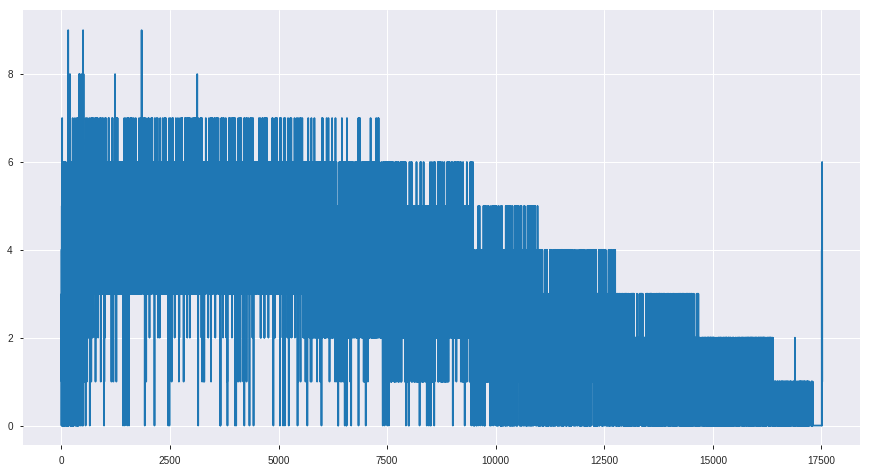

In [254]:
plt.figure(figsize = (15, 8))
plt.plot(train_data['Col120'].values)

In [227]:
lgbb = lgb.LGBMClassifier()
lgbb.fit(train_data.values, train['Col2'].values)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [228]:
xgbb = xgb.XGBClassifier()
xgbb.fit(train_data.values, train['Col2'].values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [229]:
ctb = CatBoostClassifier(verbose=False)


ctb.fit(train_data.values, train['Col2'].values)

In [230]:
result1 = lgbb.predict_proba(test_data.values)
result2 = xgbb.predict_proba(test_data.values)
result3 = ctb.predict_proba(test_data.values)

In [231]:
resultt = 0.4 * result1 + 0.2 * result2 + 0.4 * result3

In [232]:
result = np.argmax(resultt, axis=1)

In [233]:
submission = pd.DataFrame()
submission['Col1'] = test['Col1']
submission['Col2'] = result

In [234]:
submission.to_csv('submission.csv', index=False)

In [235]:
submission.head()

,Col1,Col2
0,RIGD58ZWD,0
1,RIH660YDS,0
2,RIH660Q96,0
3,RIYDO15W1,0
4,RIYBGC1ZD,0
